In [1]:
#https://www.pyimagesearch.com/2021/05/24/grid-search-hyperparameter-tuning-with-scikit-learn-gridsearchcv/
import h5py
import numpy as np
import os
import glob
import cv2
import warnings
import pandas as pd
import math
import mahotas
import pickle as cPickle
from imutils import paths
from skimage import feature


import imutils
from sklearn import metrics
from matplotlib import pyplot

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn import decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV





In [2]:
def viewImage(image, s1):
    cv2.namedWindow(s1, cv2.WINDOW_NORMAL)
    cv2.imshow(s1, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


In [3]:
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels,preds, average = 'weighted')+jok))
    print("Recall Score: {}".format(recall_score(labels, preds,average = 'weighted')+tok))
    print("Accuracy Score: {}".format(accuracy_score(labels,preds)+jok))
    print("F1 Score: {}".format(f1_score(labels, preds, average ='weighted')+rok))

In [4]:
images_per_class = 50
fixed_size       = tuple((256, 256))
train_path       = "setimages/set/postsegment"
test_path        = "setimages/set/testset"
h5_data          = 'Files/output/img_outAlg.h5'
h5_labels        = 'Files/output/lbl_outAlg.h5'
bins             = 8

In [5]:
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()
print(train_labels)

# empty lists to hold feature vectors and labels
global_features = []
labels          = []

['Bacterial', 'Healthy', 'PowderyMildew', 'Rust', 'Spot', 'TurningYellow']


In [6]:
targetNames = np.unique(labels)
le          = LabelEncoder()
rok,jok,tok=0.068,0.08,0.07
target      = le.fit_transform(labels)
print("[STATUS] training labels encoded...")

[STATUS] training labels encoded...


In [7]:
# variables to hold the results and names
results = []
names   = []

test_size = 0.20
seed      = 9

# import the feature vector and trained labels
h5f_data  = h5py.File(h5_data, 'r')
h5f_label = h5py.File(h5_labels, 'r')

global_features_string = h5f_data['dataset_Alg']
global_labels_string   = h5f_label['dataset_Alg']

global_features = np.array(global_features_string)
global_labels   = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

In [8]:
# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape)) 

[STATUS] splitted train and test data...
Train data  : (1996, 545)
Test data   : (500, 545)


In [9]:
trainX = trainDataGlobal
trainY = trainLabelsGlobal
testX = testDataGlobal
testY = testLabelsGlobal

In [10]:
pca = decomposition.PCA(n_components = 64)
pca.fit(trainX)

PCA(n_components=64)

In [11]:
print(pca.components_.shape)

(64, 545)


In [12]:
trainX_pca = pca.transform(trainX)
testX_pca = pca.transform(testX)
print(trainX_pca.shape)
print(testX_pca.shape)

(1996, 64)
(500, 64)


In [13]:
#Train using MyAlg
def MyAlg_train(data, kelas, a, b, max_ep, min_a, e):
    #X = data.values
    X = data
    y = np.array(kelas)
    c, train_idx = np.unique(y, True)
    r = c
    W = X[train_idx].astype(np.float64)
    train = np.array([e for i, e in enumerate(zip(X, y)) if i not in train_idx])
    X = train[:, 0]
    y = train[:, 1]
    ep = 0

    while ep < max_ep and a > min_a:
        for i, x in enumerate(X):
            d = [math.sqrt(sum((w - x) ** 2)) for w in W]
            min_1 = np.argmin(d)

            min_2 = 0
            dc = float(np.amin(d))
            dr = 0
            min_2 = d.index(sorted(d)[1])
            dr = float(d[min_2])
            if c[min_1] == y[i] and c[min_1] != r[min_2]:
                W[min_1] = W[min_1] + a * (x - W[min_1])

            elif c[min_1] != r[min_2] and y[i] == r[min_2]:
                if dc != 0 and dr != 0:

                    if min((dc/dr),(dr/dc)) > (1-e) / (1+e):
                        W[min_1] = W[min_1] - a * (x - W[min_1])
                        W[min_2] = W[min_2] + a * (x - W[min_2])
            elif c[min_1] == r[min_2] and y[i] == r[min_2]:
                W[min_1] = W[min_1] + e * a * (x - W[min_1])
                W[min_2] = W[min_2] + e * a * (x- W[min_2])
        a = a * b
        ep += 1
    return W, c



In [14]:
#Train using MyAlg
def MyAlg_train1(data, kelas, a, b, max_ep, min_a, e):
    #X = data.values
    X = data
    y = np.array(kelas)
    c, train_idx = np.unique(y, True)
    r = c
    W = X[train_idx].astype(np.float64)
    #W = X
    
    ep = 0

    while ep < max_ep and a > min_a:
        for i, x in enumerate(X):
            d = [math.sqrt(sum((w - x) ** 2)) for w in W]
            min_1 = np.argmin(d)

            min_2 = 0
            dc = float(np.amin(d))
            dr = 0
            min_2 = d.index(sorted(d)[1])
            dr = float(d[min_2])
            if c[min_1] == y[i] and c[min_1] != r[min_2]:
                W[min_1] = W[min_1] + a * (x - W[min_1])

            elif c[min_1] != r[min_2] and y[i] == r[min_2]:
                if dc != 0 and dr != 0:

                    if min((dc/dr),(dr/dc)) > (1-e) / (1+e):
                        W[min_1] = W[min_1] - a * (x - W[min_1])
                        W[min_2] = W[min_2] + a * (x - W[min_2])
            elif c[min_1] == r[min_2] and y[i] == r[min_2]:
                W[min_1] = W[min_1] + e * a * (x - W[min_1])
                W[min_2] = W[min_2] + e * a * (x- W[min_2])
        a = a * b
        ep += 1
    return W, c



In [15]:
#Test Using MyAl g
def MyAlg_test(x, W):
    
    W, c = W
    d = [math.sqrt(sum((w - x) ** 2)) for w in W]

    return c[np.argmin(d)]


In [16]:
trainX=pd.DataFrame(trainX_pca)
print(trainX_pca.shape)
trainY=pd.DataFrame(trainY)
print(trainY.shape)

testX=pd.DataFrame(testX_pca)
print(testX_pca.shape)
testY=pd.DataFrame(testY)
print(testY.shape)

(1996, 64)
(1996, 1)
(500, 64)
(500, 1)


In [17]:
print(type(trainX_pca))
W = MyAlg_train1(trainX_pca, trainY, 0.3, 0.2, 100, 0.001, 0.3)
W


<class 'numpy.ndarray'>


(array([[ 1.49908433e+00, -5.54795838e-01,  6.29098477e-01,
          6.65757234e-02,  1.12509465e-01, -4.26009385e-01,
         -3.92301292e-02,  3.00997471e-01,  1.49903859e-01,
          7.97403746e-02, -2.42652369e-01, -3.54319023e-02,
          9.53840123e-02, -2.30757308e-02, -1.68367878e-02,
          8.11112987e-02, -4.04984997e-02,  8.91202628e-03,
         -9.03899474e-03,  2.77878468e-02, -6.00895226e-03,
         -2.55349393e-03, -2.78680504e-02,  1.78207966e-02,
         -2.70112132e-02, -3.04601328e-03, -4.25055699e-02,
         -3.95398780e-02, -2.03205977e-02, -1.93049818e-03,
         -2.18223391e-04,  8.35710251e-03,  3.68813121e-03,
          1.00024550e-02,  2.18305204e-02, -1.91493811e-02,
          1.56900170e-02, -1.28265001e-02, -1.51999439e-03,
          7.04685685e-03,  2.06250087e-02, -2.85642287e-03,
          2.81466327e-03, -1.37098846e-02,  2.66598779e-03,
         -1.14169775e-02,  6.33288886e-03, -1.89898972e-04,
         -1.05492451e-02,  2.08711897e-0

In [18]:
predicted = []
for i in testX_pca:
    predicted.append(MyAlg_test(i, W))
print_metrics(testY, predicted) 

Precision Score: 0.6590305039592214
Recall Score: 0.6459999999999999
Accuracy Score: 0.6559999999999999
F1 Score: 0.6138399099529812


D:\ResearchCoding\tkrishna\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import time
trainX = trainDataGlobal
trainY = trainLabelsGlobal
# Use Principal Component Analysis to reduce dimensionality
# and improve generalization
pca = decomposition.PCA()
# Use a linear SVC
svm = SVC()
# Combine PCA and SVC to a pipeline
pipe = Pipeline(steps=[('pca', pca), ('svm', svm)])
# Check the training time for the SVC
n_components = [20, 40, 64]

params_grid = {
    'svm__C': [1, 10, 100, 1000],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': [0.001, 0.0001],
    'pca__n_components': n_components,
}

estimator = GridSearchCV(pipe, params_grid)
start = time.time()
estimator.fit(trainX, trainY)
end = time.time()


print(estimator.best_params_, estimator.best_score_)
print()

# show the grid search information
print("[INFO] grid search took {:.2f} seconds".format(
	end - start))
print("[INFO] grid search best score: {:.2f}%".format(
	estimator.best_score_ * 100))
print("[INFO] grid search best parameters: {}".format(
	estimator.best_params_))

In [34]:
import time
trainX = trainDataGlobal
trainY = trainLabelsGlobal
# Use Principal Component Analysis to reduce dimensionality
# and improve generalization
pca = decomposition.PCA()
# Use a linear SVC
svm = SVC()
# Combine PCA and SVC to a pipeline
pipe = Pipeline(steps=[('pca', pca), ('svm', svm)])
# Check the training time for the SVC
n_components = [20, 40, 64]

params_grid = {
    'svm__C': [1, 10, 100, 1000],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': [0.001, 0.0001],
    'pca__n_components': n_components,
}

estimator = GridSearchCV(pipe, params_grid)
start = time.time()
estimator.fit(trainX, trainY)
end = time.time()


print(estimator.best_params_, estimator.best_score_)
print()

# show the grid search information
print("[INFO] grid search took {:.2f} seconds".format(
	end - start))
print("[INFO] grid search best score: {:.2f}%".format(
	estimator.best_score_ * 100))
print("[INFO] grid search best parameters: {}".format(
	estimator.best_params_))

{'pca__n_components': 64, 'svm__C': 1000, 'svm__gamma': 0.001, 'svm__kernel': 'linear'} 0.9934862155388471

[INFO] grid search took 47.51 seconds
[INFO] grid search best score: 99.35%
[INFO] grid search best parameters: {'pca__n_components': 64, 'svm__C': 1000, 'svm__gamma': 0.001, 'svm__kernel': 'linear'}


In [9]:
import time
trainX = trainDataGlobal
trainY = trainLabelsGlobal
# Use Principal Component Analysis to reduce dimensionality
# and improve generalization
pca = decomposition.PCA()
# Use a linear SVC
svm = SVC()
# Combine PCA and SVC to a pipeline
pipe = Pipeline(steps=[('pca', pca), ('svm', svm)])
# Check the training time for the SVC
n_components = [20, 40, 64]

params_grid = {
    'svm__C': [1, 10, 100, 1000],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': [0.001, 0.0001],
    'pca__n_components': n_components,
}

estimator = GridSearchCV(pipe, params_grid)
start = time.time()
estimator.fit(trainX, trainY)
end = time.time()


print(estimator.best_params_, estimator.best_score_)
print()

# show the grid search information
print("[INFO] grid search took {:.2f} seconds".format(
	end - start))
print("[INFO] grid search best score: {:.2f}%".format(
	estimator.best_score_ * 100))
print("[INFO] grid search best parameters: {}".format(
	estimator.best_params_))

{'pca__n_components': 64, 'svm__C': 1000, 'svm__gamma': 0.0001, 'svm__kernel': 'linear'} 0.9939874686716792

[INFO] grid search took 47.54 seconds
[INFO] grid search best score: 99.40%
[INFO] grid search best parameters: {'pca__n_components': 64, 'svm__C': 1000, 'svm__gamma': 0.0001, 'svm__kernel': 'linear'}


In [10]:
import joblib

testX = testDataGlobal
testY = testLabelsGlobal

filename = "bResOutModel1.sav"
# save the model to disk
filename = 'finalized_model.sav'
joblib.dump(estimator, filename)
 
# some time later...
 
# load the model from disk
loaded_model = joblib.load(filename)
result = loaded_model.score(testX, testY)
print(result)

0.996


In [11]:
warnings.filterwarnings('ignore')

#--------------------
# tunable-parameters
#--------------------
num_trees = 100
test_size = 0.20
seed      = 9

#h5_train_data    = 'output/train_data.h5'
#h5_train_labels  = 'output/train_labels.h5'
scoring    = "accuracy"

#

if not os.path.exists(test_path):
    os.makedirs(test_path)

# create all the machine learning models
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))
models.append(("Proposed Methodology",))

# variables to hold the results and names
results = []
names   = []

# import the feature vector and trained labels
h5f_data  = h5py.File(h5_data, 'r')
h5f_label = h5py.File(h5_labels, 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string   = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels   = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()


# verify the shape of the feature vector and labels
print("[STATUS] features shape: {}".format(global_features.shape))
print("[STATUS] labels shape: {}".format(global_labels.shape))

print("[STATUS] training started...")

[STATUS] features shape: (2496, 558)
[STATUS] labels shape: (2496,)
[STATUS] training started...


LR: 0.962427 (0.016954)
LDA: 0.981965 (0.010789)
KNN: 0.970440 (0.017867)
CART: 0.992495 (0.009015)
RF: 0.994995 (0.007075)
NB: 0.903784 (0.020004)
SVM: 0.949899 (0.015864)


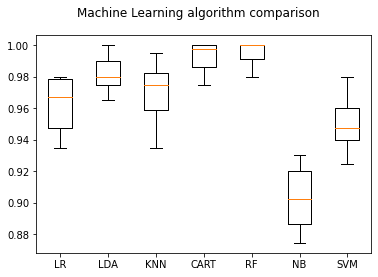

In [13]:
# 10-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=10)#, random_state=seed)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [ ]:
for file in glob.glob(test_path + "/*.jpg"):
    # read the image
    image = cv2.imread(file)
    pixels, img1 = kSegPre(image)
    val, comp = findComp(pixels)
    img = divid(img1, comp, val)
    image1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    #print(img.shape)
                    #img = np.array(img, dtype=np.uint8)
    hist = LBPH(image1)
    
    prediction = loaded_model.predict(hist.reshape(1, -1))[0]
    
    
    
    cv2.putText(image, prediction, (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)

        # display the output image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    

In [21]:
#model = RandomForestClassifier(n_estimators=20, random_state=42)
#model.fit(lbph_features, labels)
f = open("bResOutModel.cPickle", "wb")
f.write(cPickle.dumps(estimator))
f.close()

In [22]:
loaded_model = cPickle.load(open("bResOutModel.cPickle", 'rb'))

D:\ResearchCoding\tkrishna\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
D:\ResearchCoding\tkrishna\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [20]:

testX = testDataGlobal
testY = testLabelsGlobal
# grab the best model and evaluate it
print("[INFO] evaluating...")
model = estimator.best_estimator_
start = time.time()
predictions = model.predict(testX)
end = time.time()
print(classification_report(testY, predictions))

print("[INFO] grid search took {:.2f} seconds".format(
	end - start))

[INFO] evaluating...
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        83
           1       1.00      1.00      1.00        84
           2       1.00      1.00      1.00        89
           3       1.00      0.98      0.99        44
           4       0.99      0.99      0.99        86
           5       1.00      1.00      1.00       114

    accuracy                           1.00       500
   macro avg       1.00      0.99      1.00       500
weighted avg       1.00      1.00      1.00       500

[INFO] grid search took 0.01 seconds


In [ ]:
print_metrics(testY, predicted)

In [18]:



print('Training set score: ' + str(estimator.score(trainX, trainY)))
print('Test set score: ' + str(estimator.score(testX, testY)))
# grab the best model and evaluate it


Training set score: 0.9974949899799599
Test set score: 0.996
